<a href="https://colab.research.google.com/github/marcogemaque/calculadora-aluguel-turma-set-20/blob/main/Awari_DS_Rent_Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Webscraping and processing of file**

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep
import re

In [ ]:
#Let's create a function to retrieve all the rent values
bairros = ['badu','barreto','baldeador','boa-viagem','camboinhas','centro','cubango','cantagalo','charitas',
           'engenho-do-mato','engenhoca','fonseca','fatima','gragoata','icarai','inga','itaipu',
           'ilha-da-conceicao','itacoatiara','jacare','jardim-fluminense','jardim-icarai',
           'largo-do-narradas','largo-da-batalha','maceio','maria-paula','maravista','matapaca',
           'pendotiba',"ponta-dareia",'piratininga','pe-pequeno','rio-do-ouro','santa-rosa',
           'serra-grande','sao-lourenco','santana','sao-domingos','sape','sao-francisco','tenente-jardim',
           'vital-brazil','varzea-das-mocas'] #List created to search in neighborhoods
paginas = ['', '_Desde_49', '_Desde_97', '_Desde_145', '_Desde_193', 
           '_Desde_241', '_Desde_289']

In [ ]:
def get_rents(x, hood, soup):
    #Function created to fetch rent, m², area and state and other important info
    tag_rent = soup.find_all('span',{"class":"price-tag-fraction"})
    list_rent = [r.text for r in tag_rent] #Create rent list
    tag_street = soup.find_all('h2',{"class":"ui-search-item__title ui-search-item__group__element"})
    list_street = [r.text for r in tag_street] #Create street rent

    if len(list_street) < len(list_rent):
        while len(list_street) < len(list_rent):
            list_street.append(" ")
    elif len(list_rent) < len(list_street):
        while len(list_rent) < len(list_street):
            list_rent.append("0")

    tag_area = soup.find_all('ul',{"class":'ui-search-card-attributes'})
    list_area = [r.text for r in tag_area] #Create area list
    if len(list_area) < len(list_rent):
        while len(list_area) < len(list_rent):
            list_area.append(0)
    elif len(list_rent) < len(list_area):
        while len(list_rent) < len(list_area):
            list_rent.append(0)

    df = pd.DataFrame(
        {'Rent':list_rent,
         'Street':list_street,
         'Area':list_area,
         'Hood':hood})
    
    df['Total-Area'] = df['Area'].str.split("[m]+")
    df['Total-Area'] = df['Total-Area'].str[0]
    df['Rooms'] = df['Area'].str.split("[construídos]+").str[1]
    df['Rooms'] = df['Rooms'].str[0]
    #df = df.drop(['Area'],axis=1) #Still not necessary
    df['Rooms'] = df['Rooms'].fillna(0)
    df['Rooms'] = pd.to_numeric(df['Rooms'])
    df['Rooms'] =df['Rooms'].replace(0,df.loc[df['Rooms'] > 0, 'Rooms'].mean())
    df['Total-Area'] = df['Total-Area'].replace("\,","",regex=True)
    df['Total-Area'] = pd.to_numeric(df['Total-Area'])
    df['Rent'] = df['Rent'].replace("\.","",regex=True)
    df['Rent'] = pd.to_numeric(df['Rent'])
    return df

In [ ]:
df = pd.DataFrame(columns=["Rent","Street","Area","Hood","Total-Area","Rooms"])
url = 'https://imoveis.mercadolivre.com.br/aluguel/rio-de-janeiro/niteroi/'
for bairro in bairros:
    for pag in paginas:
        urls = url + "/{}/{}".format(bairro,pag)
        page = requests.get(urls)
        soup = BeautifulSoup(page.content,'html.parser')
        print('Currently scraping: {}'.format(urls))
        page = requests.get(urls)
        try:
            df_int = get_rents(page,bairro,soup)
            print(df_int.head())
            list_dfs = [df, df_int]
            df = pd.concat(list_dfs)
            sleep(1)
        except:
            print('exception')
            sleep(1)
            pass

Currently scraping: https://imoveis.mercadolivre.com.br/aluguel/rio-de-janeiro/niteroi//badu/
   Rent                    Street  ... Total-Area Rooms
0  2100  Estrada Caetano Monteiro  ...         69     3
1  1650  Estrada Caetano Monteiro  ...         70     2
2  4800                            ...        300     5
3  3500  Estrada Caetano Monteiro  ...         90     3
4  1300              391 Bloco 06  ...         82     2

[5 rows x 6 columns]
Currently scraping: https://imoveis.mercadolivre.com.br/aluguel/rio-de-janeiro/niteroi//badu/_Desde_49
exception
Currently scraping: https://imoveis.mercadolivre.com.br/aluguel/rio-de-janeiro/niteroi//badu/_Desde_97
exception
Currently scraping: https://imoveis.mercadolivre.com.br/aluguel/rio-de-janeiro/niteroi//badu/_Desde_145
exception
Currently scraping: https://imoveis.mercadolivre.com.br/aluguel/rio-de-janeiro/niteroi//badu/_Desde_193
exception
Currently scraping: https://imoveis.mercadolivre.com.br/aluguel/rio-de-janeiro/niteroi//badu/_

In [ ]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1330 entries, 0 to 2
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rent        1330 non-null   object
 1   Street      1330 non-null   object
 2   Area        1330 non-null   object
 3   Hood        1330 non-null   object
 4   Total-Area  1328 non-null   object
 5   Rooms       1330 non-null   object
dtypes: object(6)
memory usage: 72.7+ KB


In [ ]:
df_out.describe()

,Rent,Street,Area,Hood,Total-Area,Rooms
count,1330,1330,1330,1330,1328.0,1330.0
unique,202,478,371,34,225.0,37.0
top,1500,,60 m² construídos2 quartos,icarai,60.0,2.0
freq,80,451,69,336,91.0,476.0


In [ ]:
df_out = df.copy()
#df_out.to_csv("consolidado.csv",sep=';',encoding='latin1')

In [ ]:
#Fix the dataframe
df_out['Total-Area'] = df_out['Total-Area'].fillna(0)
df_out['Total-Area'] = pd.to_numeric(df_out['Total-Area'])
df_out['Rent'] = pd.to_numeric(df_out['Rent'])
df_out['Rooms'] = pd.to_numeric(df_out['Rooms'])
df_out = df_out.drop(['Area'],axis=1)

KeyError: ignored

In [ ]:
df_out.to_csv("consolidado_v2.csv",sep=';',encoding='latin1')

## **EDA of the files**

### **Preprocessing**

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [54]:
url = 'https://raw.githubusercontent.com/marcogemaque/calculadora-aluguel-turma-set-20/main/1-web-scraping/consolidado_v2.csv'
df = pd.read_csv(url,sep=';',encoding='latin1').drop(['Unnamed: 0'], axis=1)

In [55]:
df.head()

,Rent,Street,Hood,Total-Area,Rooms
0,2100,Estrada Caetano Monteiro,badu,69.0,3
1,1650,Estrada Caetano Monteiro,badu,70.0,2
2,4800,NaN,badu,300.0,5
3,3500,Estrada Caetano Monteiro,badu,90.0,3
4,1300,391 Bloco 06,badu,82.0,2


In [56]:
df['Rooms'] = df['Rooms'].str.replace(',','.')
df['Rooms'] = pd.to_numeric(df['Rooms'], errors='coerce')
df_real = df.copy()

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rent        1330 non-null   int64  
 1   Street      879 non-null    object 
 2   Hood        1330 non-null   object 
 3   Total-Area  1330 non-null   float64
 4   Rooms       1330 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 52.1+ KB


In [58]:
df['Rent'] = df['Rent'].apply(lambda x: np.log(x))
df['Total-Area'] = df['Total-Area'].apply(lambda x: np.log(x) if x > 1 else 1)

### **EDA per se***

In [59]:
sns.set(style="whitegrid")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

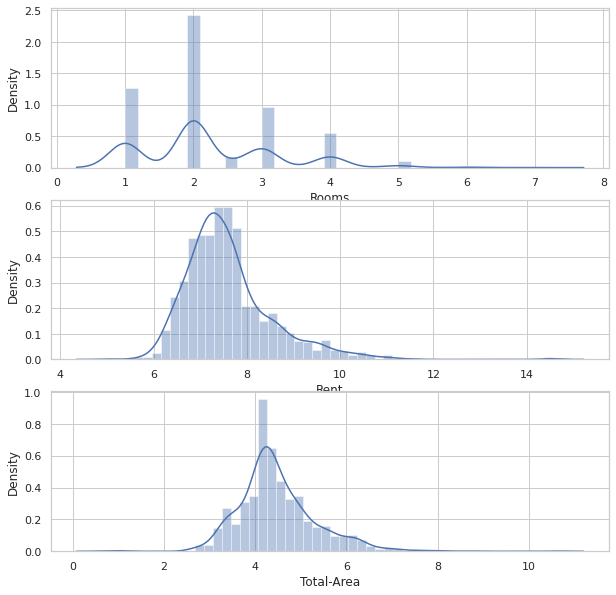

In [60]:
#Check normalization of columns

"""
Our data is strongly normalized for rent and tota-area, but we have outliers. A quick to fix to this
would be to normalize our data.
"""
f, axes = plt.subplots(3,1, figsize=(10,10))
sns.distplot(df['Rooms'], ax=axes[0])
sns.distplot(df['Rent'], ax=axes[1])
sns.distplot(df['Total-Area'], ax=axes[2])

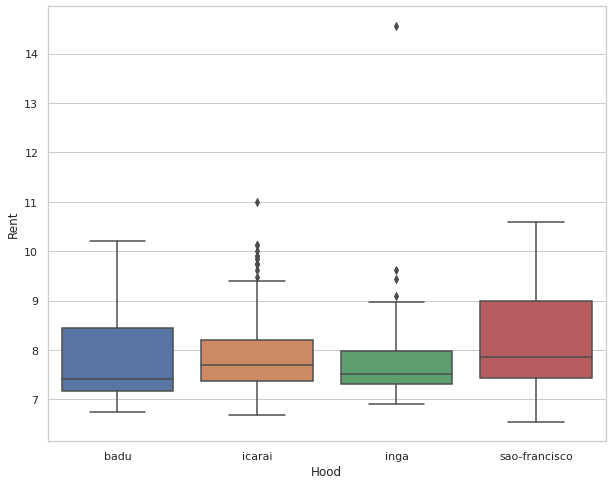

In [61]:
df_filter = df[df.Hood.isin(['badu','icarai','inga','sao-francisco'])]
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='Hood', y='Rent', data=df_filter)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


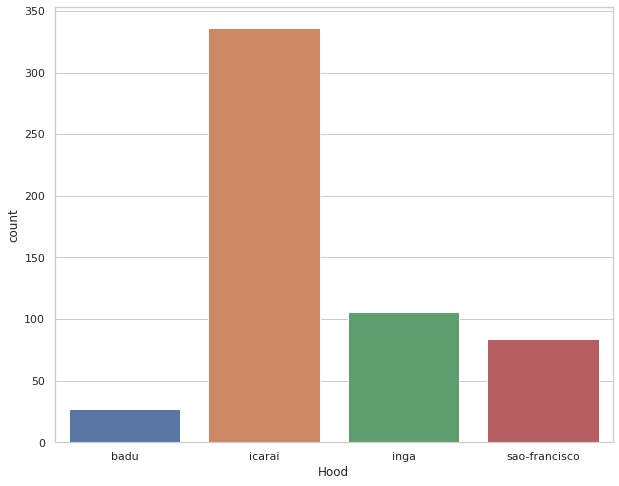

In [62]:
plt.figure(figsize=(10,8))
ax = sns.countplot(df_filter['Hood'])

<Figure size 576x720 with 0 Axes>

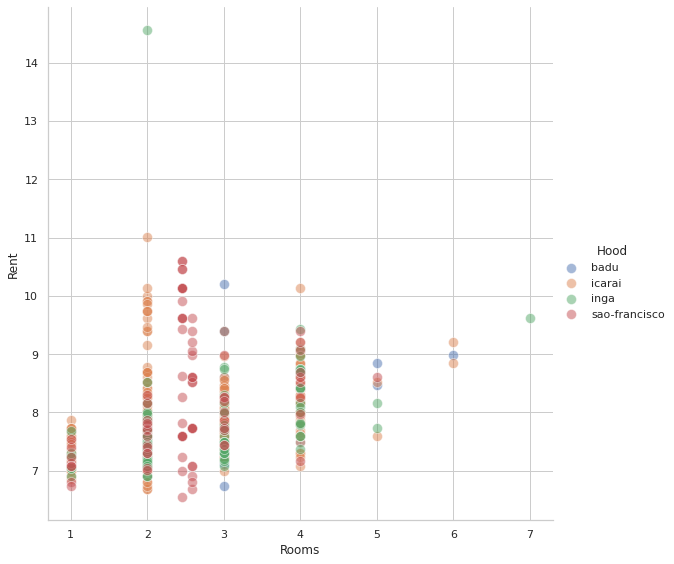

In [63]:
plt.figure(figsize=(8,10))
g = sns.FacetGrid(df_filter, hue="Hood", height=8)
g.map(sns.scatterplot, "Rooms", "Rent", s=100, alpha=.5)
g.add_legend()

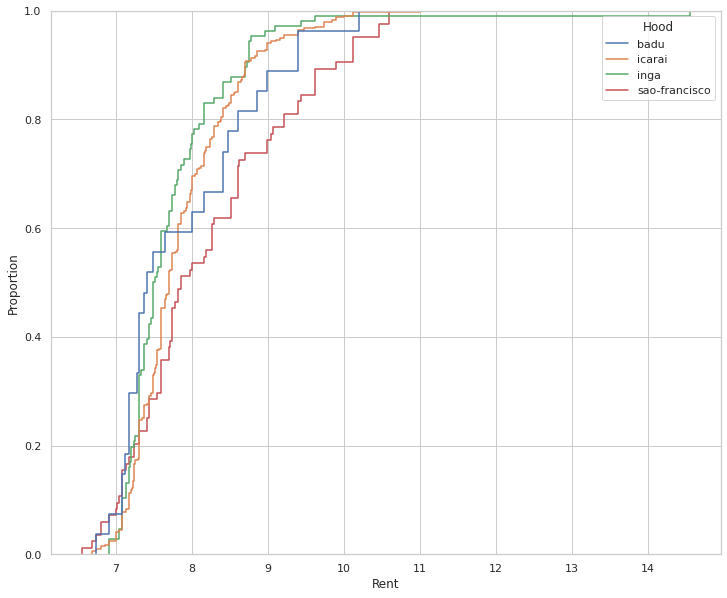

In [64]:
plt.figure(figsize=(12,10))
ax = sns.ecdfplot(data=df_filter, x="Rent", hue="Hood")

## **ML of the Files**

In [65]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#Models
from sklearn.neighbors import KNeighborsRegressor

### **OneHotEncoding All Hoods Dataframe**

In [66]:
"""
First we'll try one hot encoding hood columns and then creating prediction models.
Also we'll work with raw numbers instead of grouping and later on do feature engineering.
"""
df_work = df_real.copy()
one_hot = pd.get_dummies(df_work['Hood'])
df_work = df_work.drop(['Hood', 'Street'], axis=1)
df_work = df_work.join(one_hot)
Y = df_work.Rent
X = df_work.drop(['Rent'], axis=1)
df_work.head()

,Rent,Total-Area,Rooms,badu,baldeador,barreto,boa-viagem,camboinhas,cantagalo,centro,charitas,cubango,fatima,fonseca,gragoata,icarai,ilha-da-conceicao,inga,itacoatiara,jacare,jardim-fluminense,jardim-icarai,largo-da-batalha,largo-do-narradas,maceio,maravista,matapaca,pe-pequeno,piratininga,ponta-dareia,rio-do-ouro,santa-rosa,santana,sao-francisco,sape,tenente-jardim,vital-brazil
0,2100,69.0,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1650,70.0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4800,300.0,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3500,90.0,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1300,82.0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 577)

#### **KNN**
KNN is a good place to start because in theory all hoods should have similar characteristics, therefore prices. Let's check it out.

In [71]:
def n_estimation_KNN(_x, _y, _n):
    #Function created to calculate the best n coefficient for the KNN regressor.
    #It takes as input:
    #   _x = x data for the regression
    #   _y = y data for the regression
    #   _n = range to calculate the n coefficient
    for i in range(1,_n):
        nb = KNeighborsRegressor(n_neighbors=i) #creates the regressor
        nb.fit(_x, _y) #fits the data 
        score = nb.score(_x, _y) #runs score
        print("Score for coefficient {} was {}".format(i,score))

function = n_estimation_KNN(x_train, y_train, 20)

Score for coefficient 1 was 0.004082713403091853
Score for coefficient 2 was 0.0035259266165698078
Score for coefficient 3 was 0.002734512517443055
Score for coefficient 4 was 0.18828959172441395
Score for coefficient 5 was 0.20020346133892952
Score for coefficient 6 was 0.19452907216588178
Score for coefficient 7 was 0.18506856160177643
Score for coefficient 8 was 0.1735011669245281
Score for coefficient 9 was 0.1621595915685522
Score for coefficient 10 was 0.1495997798313714
Score for coefficient 11 was 0.14216581628360936
Score for coefficient 12 was 0.13155993874255334
Score for coefficient 13 was 0.12584559777399995
Score for coefficient 14 was 0.11894683850061694
Score for coefficient 15 was 0.11264885380377065
Score for coefficient 16 was 0.10699926061008536
Score for coefficient 17 was 0.10181218244942702
Score for coefficient 18 was 0.09706071449698628
Score for coefficient 19 was 0.07766519576020514


In a general way it was pretty crappy. But a lot of that has to do with  